#Loading dependencies

In [1]:
from IPython.display import clear_output
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/7fvgj4jsp7-1.zip
!unzip 7fvgj4jsp7-1.zip
!rm 7fvgj4jsp7-1.zip
clear_output()

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

#Data preparation

In [ ]:
data_dir = "/content/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM/images"
mask_dir = "/content/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM/masks"
info = pd.read_csv("INFO.csv", sep = ';')

data_lst = os.listdir(data_dir)

In [4]:
info

Image Resolution   Label Doppler Marks Combined
0    ALWI_000.png    856x606  Benign      No   Yes       No
1    ALWI_001.png    856x606  Normal      No    No       No
2    ALWI_002.png    856x606  Benign      No    No       No
3    ALWI_003.png    856x606  Benign      No    No       No
4    ALWI_004.png    856x606  Benign      No   Yes       No
..            ...        ...     ...     ...   ...      ...
678  WAQU_003.png    856x606  Normal      No    No       No
679  WAQU_004.png    856x606  Normal      No    No       No
680  WAQU_005.png    856x606  Normal      No    No       No
681  WAQU_006.png    856x606  Normal      No    No       No
682  WAQU_007.png    856x606  Normal      No    No       No

[683 rows x 6 columns]

The masks provided in the dataset comes as an RGB image. This might not be the case for every dataset. As such we are writing a function to return a binary mask using Boolean indexing.

In [5]:
def ret_binary(mask):
  return ((mask[:, :, 0] > 0) | (mask[:, :, 1] > 0) | (mask[:, :, 2] > 0))

Now lets say we want to visualize a random picture with the mask overlayed on top, along with the label of the image. Since the data comes from different sources, we have to do a bit of work to get there -

In [6]:
def get_data(im_name, data_dir, mask_dir, info):
  im = plt.imread(os.path.join(data_dir, im_name))
  im = skimage.color.rgb2gray(im) # original data is in rgb
  mask = plt.imread(os.path.join(mask_dir, im_name))
  mask = ret_binary(mask)
  label = info[info['Image'] == im_name]['Label'].item()

  return im, mask, label

def show_overlay(image, mask, label, alpha=0.5):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap = 'gray')  # show image
    plt.imshow(mask, cmap='Reds', alpha=alpha)  # overlay mask
    plt.axis('off')
    plt.title('Class = ' + label)
    plt.show();

Now if we pick a random image -

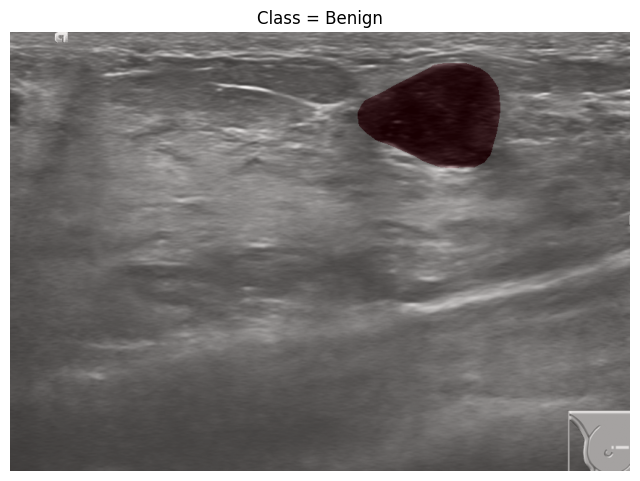

In [7]:
random_img = np.random.choice(data_lst).item()
im, mask, label = get_data(random_img, data_dir, mask_dir, info)
show_overlay(im, mask, label, alpha = 0.25)

There can be better ways to visualize. I will leave that upto you.

To train any network, we have to match each images to its corresponding mask and label. We also have to convert the image and the mask to numpy array for processing and text label to some numerical value.

For our task, since we have 3 classes, lets just map them to -


*   Normal - 0
*   Benign - 1
*   Malignant - 2

In [8]:
def read_data(data_lst, data_dir, mask_dir, info, reshape = True):
  x = []
  y_label = []
  y_mask = []
  for im_name in data_lst:
    im, mask, label = get_data(im_name, data_dir, mask_dir, info)
    if reshape:
      im = skimage.transform.resize(im, (600, 600), anti_aliasing=True)
      mask = skimage.transform.resize(mask, (600, 600), anti_aliasing=False)
    x.append(im)
    y_mask.append(mask)
    y_label.append(label)
  return np.array(x), np.array(y_mask), np.array(y_label)

In [9]:
x, y_mask, y_label = read_data(data_lst, data_dir, mask_dir, info)

label_map = {'Normal': 0, 'Benign': 1, 'Malignant': 2}

y = np.array([label_map[label] for label in y_label])

We can still check for random index for sanity check that our code did work -

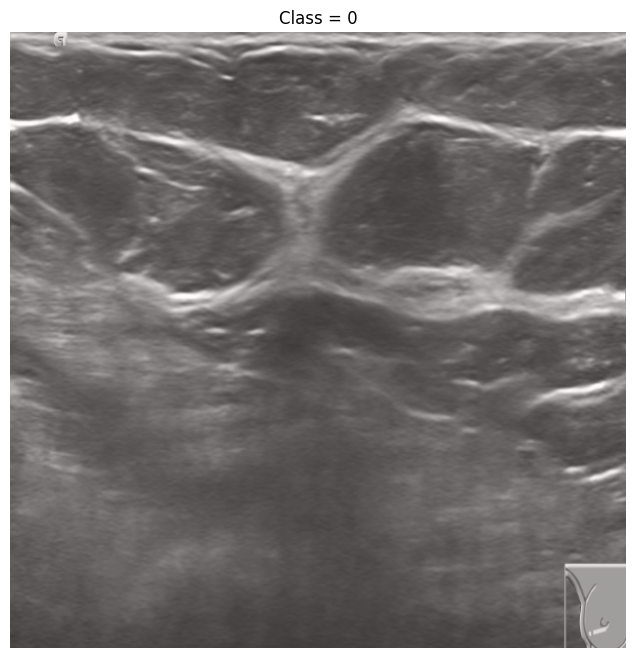

In [10]:
rand_ind = np.random.randint(0, len(data_lst))
show_overlay(x[rand_ind], y_mask[rand_ind], str(y[rand_ind]), alpha = 0.25)

Having loaded and processed (not really) the data, we prepare it for training. At first, we do a train test split and then we separately normalize (z-score normalization) each set.

For the split, I opted for stratified split because of the class imbalance -

In [11]:
train_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.1, stratify=y,random_state=125)

x_train = x[train_idx]
x_test = x[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]
y_mask_train = y_mask[train_idx]
y_mask_test = y_mask[test_idx]

x_train = (x_train - x_train.mean(axis = 0, keepdims = True))/(x_train.std(axis = 0, keepdims = True) + 1e-4)
x_test = (x_test - x_test.mean(axis = 0, keepdims = True))/(x_test.std(axis = 0, keepdims = True) + 1e-4)

Stratified sampling keeps the original class ratio same in both the sets. Also since we have direct access to the dataset, its fine if a validation set is not created.

I expect you to understand the batch loader yourself.

In [12]:
class BatchLoader():
    def __init__(self, x, y_mask, y_label, shuffle = True, batch_size = 32, device = 'cpu'):
        self.x = x
        self.y_mask = y_mask
        self.y_label = y_label
        self.batch_size = batch_size
        self.len = np.ceil(len(x)/batch_size).astype(int)
        self.indices = np.arange(len(x))
        self.shuffle = shuffle
        if self.shuffle:
            np.random.shuffle(self.indices)
        self.iter = 0
        self.device = device

    def next(self, task = 'classification'):
        start = self.iter * self.batch_size

        if self.iter  < self.len - 1:
            idx = self.indices[start:start + self.batch_size]
            self.iter += 1
        else:
            idx = self.indices[start:]
            self.iter = 0
            if self.shuffle:
                np.random.shuffle(self.indices)

        if task == 'classification':
            batch_x = self.x[idx]
            batch_y = self.y_label[idx]

        elif task == 'segmentation':
            batch_x = self.x[idx]
            batch_y = self.y_mask[idx]

        elif task == 'both':
            batch_x = self.x[idx]
            batch_y_mask = self.y_mask[idx]
            batch_y_label = self.y_label[idx]

            return torch.tensor(batch_x, device = self.device), torch.tensor(batch_y_label, device = self.device), torch.tensor(batch_y_mask, device = self.device)

        return torch.tensor(batch_x, device = self.device), torch.tensor(batch_y, device = self.device)

#U-Net

##Creating a U-Net model

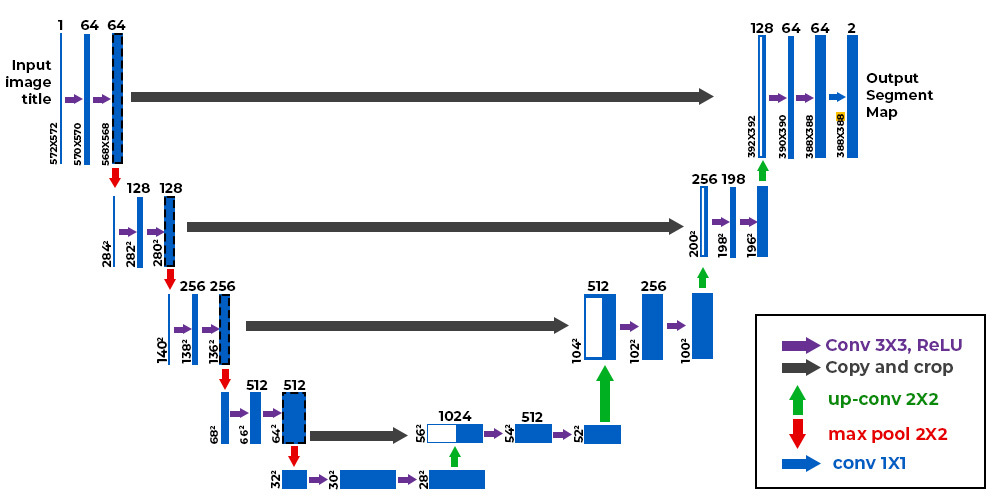

Here the dimension is getting reduced after each convolution layer as no padding has been used. But we will make our lives a bit easier for us by including padding. For more details, please go through the original paper - https://arxiv.org/abs/1505.04597

There are two convolutional layers at each depth. Instead of coding it every time, lets define a double convolution block -

In [13]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

The left hand side of the U is the encoder. At each depth the image representation is downsampled by 2. Having coded the double conv layer, lets code the encoder separately. We also extract the intermediate depth outputs as well for our bypass paths to the decoder.

In [14]:
class UNetEncoder(nn.Module):
    def __init__(self, in_channels, first_out_channel=16):
        super().__init__()

        self.enc1 = ConvBlock(in_channels, first_out_channel)
        self.enc2 = ConvBlock(first_out_channel, first_out_channel*2)
        self.enc3 = ConvBlock(first_out_channel*2, first_out_channel*4)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #pooling layer can be reused as there are no learnable parameters

    def forward(self, x):
        x1 = self.enc1(x)              # 16 channels x 600
        x2 = self.enc2(self.pool(x1))  # 32 channels x 300
        x3 = self.enc3(self.pool(x2))  # 64 channels x 150

        return x1, x2, x3

Now lets code the bottleneck layer -

In [15]:
class UNetBottleneck(nn.Module):
  def __init__(self, in_channels):
    super().__init__()

    self.enc = ConvBlock(in_channels, in_channels*2)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    return self.enc(self.pool(x))

Similar to the encoder, lets make our lives a bit easier by coding the decoder block used at every depth -

In [16]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()

        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(2*out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        #the 2*out_channels in the first conv is used to accomodate the skip connection

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([skip, x], dim=1)
        x = self.conv(x)
        return x

What is the `ConvTranspose2d`? It is the inverse of convolution, also called deconvolution.

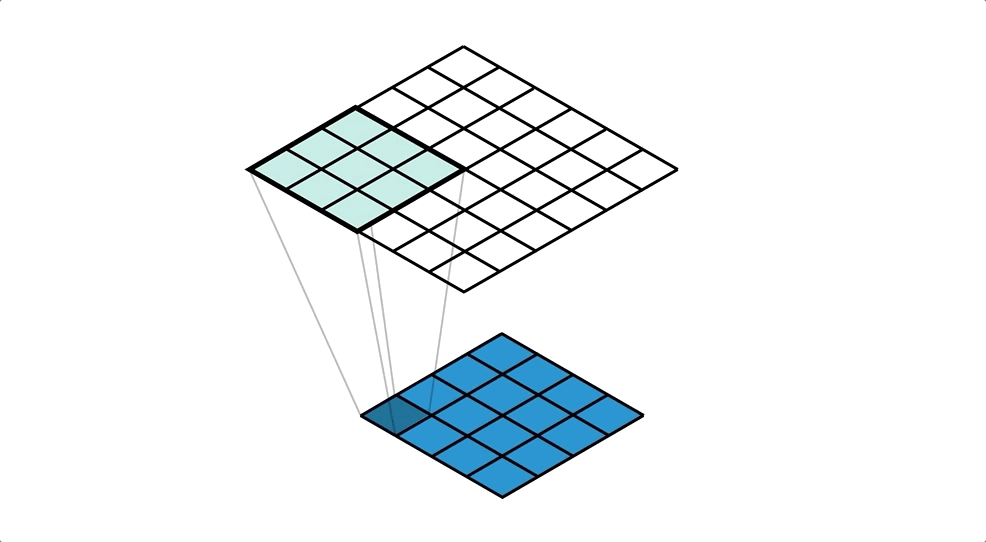

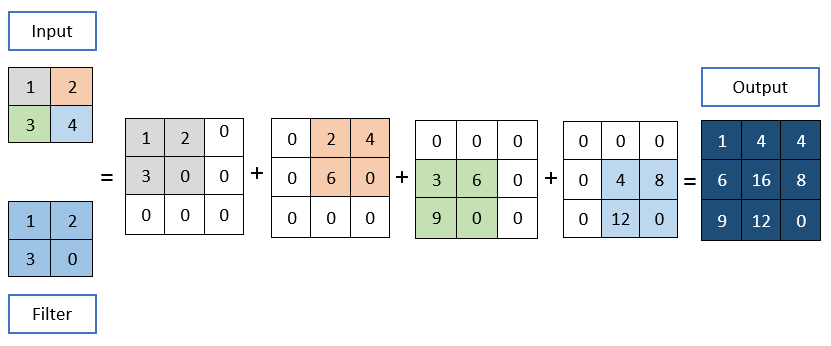

Finally the decoder -

In [17]:
class UNetDecoder(nn.Module):
    def __init__(self, in_channels = 128):
        super().__init__()

        self.decode1 = DecoderBlock(in_channels=in_channels, out_channels=in_channels//2)
        self.decode2 = DecoderBlock(in_channels=in_channels//2, out_channels=in_channels//4)
        self.decode3 = DecoderBlock(in_channels=in_channels//4, out_channels=in_channels//8)

        self.final_conv = nn.Conv2d(in_channels//8, 1, kernel_size=1)  # Output 1 channel for binary segmentation

    def forward(self, x4, x3, x2, x1):
        x3 = self.decode1(x4, x3) # 64 channels x 150
        x2 = self.decode2(x3, x2)  # 32 channels x 300
        x1 = self.decode3(x2, x1)  # 16 channels x 600
        x = self.final_conv(x1).squeeze(1) #1 channel x 600
        return x

Please note that the U-Net coded here is a shorter variant. For your project, you have to code the full version. For this implementation we will keep our channel numbers low too -

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder = UNetEncoder(1, 8).to(device)
bottleneck = UNetBottleneck(32).to(device)
decoder = UNetDecoder(64).to(device)
#For each depth, the channel size doubles. Depth = 3 means a 3 times increase
#The bottleneck layer also doubles the channel size. Hence the total increase is 3+1 = 4

Now having instantiated the model, we need to train it. We know how to do that. But we don't know about the segmentation losses that we should use. So lets talk about them.

##Defining losses

### Loss 1 -

The masks we are using for this task are binary in nature. The masks themselves do not have any class information and are separately stored in the labels. No images have lumped separate classes. As such, can we not think of the segmentation problem as individual pixel classification? Our model just needs to learn whether pixel, $x_{i,j}$ belongs to the mask or not. So, the whole problem boils down to a binary classification problem. So, we can simply use binary cross entropy (BCE) loss.

However remember that all our models output logits and not probabilities. Our U-Net will also output logits. So, instead of basic BCE loss, we will use `BCEWithLogitsLoss()` so that we do not need to convert the logits to probabilities before getting the loss. The loss instance will expect our input in the form - `loss_instance(logit_map, original_mask)`. The function can handle 2D arrays without further manipulation.

### Loss 2 -

To aid the model in localizing the mask on top of the real mask (when present), we will use an additional loss - Dice loss. While BCE loss will suffice in this case, since we are evaluating the model on IoU (Intersection over Union) metric, it is better to include a loss function that mimics the metric for better performance.

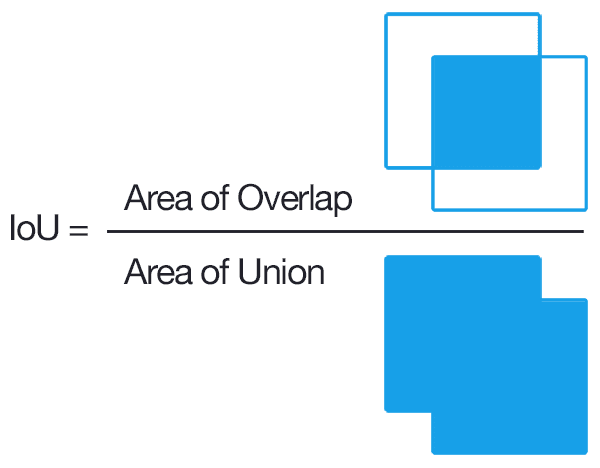

IoU can be represented in percentage similar to accuracy. The higher the IoU, the better. Since our goal is to maximize the IoU metric, can we not use it directly as our loss function?

The answer is no. The intersection and union operation are set operations and in the case of our problem we need to have the predicted mask to calculate the IoU. However, remember that our model outputs logits. So, how can we go from logits $\in (-∞, ∞$) to binary mask $\in \{0, 1\}$?

$$Logits \xrightarrow[]{Sigmoid} Probabilities \xrightarrow[]{Thresholding} Binary \ mask $$

However, the thresholding operation cannot be backpropagated as it is discontinuous. Hence, IoU cannot be used as a loss function because IoU cannot be propagated backwards.

So what can we do? We use dice loss.

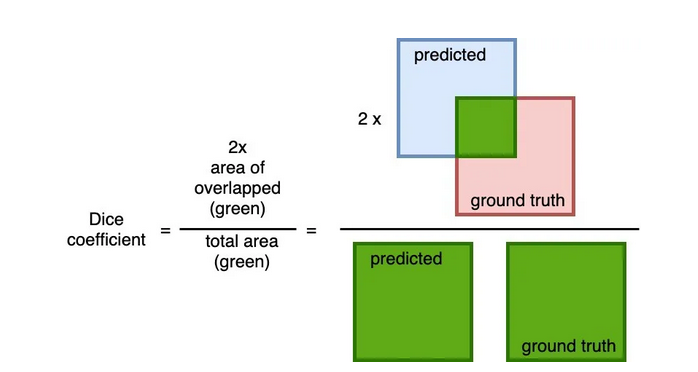

Dice loss is defined as -

$$Dice \ loss = 1 - Dice \ coefficient$$

The dice coefficient is very similar to the IoU metric and it can be backpropagated. Look at the formulas and see if you can see the similarities -

$$IoU = \frac{n(A\cap B)}{n(A\cup B)}=\frac{n(A\cap B)}{n(A) + n(B) - n(A\cap B)}$$

$$Dice \ coefficient = \frac{2*P(A)*P(B)}{P(A) + P(B)}$$

Instead of count, we are taking the probability values and instead of intersection, we are doing multiplication. The denominator is missing the intersection term and so to balance out this ommision so that dice coefficient remaians in the range $[0, 1]$, we are multiplying the denominator with a 2.

Please note that these two metrics have different motivations theoretically, but for the sake of simplicity, we will consider dice to be the approximate differentiable version of IoU.

Now, for the implementation, PyTorch doesn't have a built in dice loss function and so we have to manually define it -

In [19]:
class DiceLoss(nn.Module):
    def __init__(self, epsilon=1.):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)  # raw logits to probabilities

        intersection = (preds * targets).sum()
        dice_loss = 1 - (2. * intersection + self.epsilon) / (preds.sum() + targets.sum() + self.epsilon)

        return dice_loss

Why are we using the epsilon variable? Hint - in its original formulation, what would the dice loss value be in case of a normal image (no mask)?

We also have to define the IoU metric as PyTorch does not have the implementation -

In [20]:
def calculate_iou(y_pred, y_true, threshold=0.5, eps=1e-6):
    y_pred = torch.sigmoid(y_pred)
    y_pred = (y_pred > threshold).float() #making it binaray

    y_pred = y_pred.view(y_pred.shape[0], -1)
    y_true = y_true.view(y_true.shape[0], -1)

    intersection = (y_pred * y_true).sum(dim = 1)
    union = y_pred.sum(dim = 1) + y_true.sum(dim = 1) - intersection

    # Compute IoU
    iou = (intersection + eps) / (union + eps)
    return iou.mean()

##Training our U-Net

In [21]:
train_loader = BatchLoader(x_train, y_mask_train, y_train, shuffle = True, batch_size = 8, device = device)
test_loader = BatchLoader(x_test, y_mask_test, y_test, shuffle = False, batch_size = 8, device = device)

In [22]:
optim = torch.optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr = 0.05) #AdamW is used for regularization
dice_loss = DiceLoss()
bce_loss = nn.BCEWithLogitsLoss()

epochs = 5

for epoch in range(epochs):
    print(f"Epoch - {epoch + 1}")

    train_bce_loss = 0
    train_dice_loss = 0
    train_iou = 0

    encoder.train()
    decoder.train()

    for i in range(train_loader.len):
        x, y_true = train_loader.next('segmentation')
        x1, x2, x3 = encoder(x.unsqueeze(1))
        x4 = bottleneck(x3)
        y_predict = decoder(x4, x3, x2, x1)

        bce = bce_loss(y_predict, y_true.float())
        dice = dice_loss(y_predict, y_true)

        #these weights may not give you the best results
        loss = 0.2*bce + 0.8*dice

        train_bce_loss += bce
        train_dice_loss += dice
        train_iou += calculate_iou(y_predict, y_true.float())

        optim.zero_grad()
        loss.backward()
        optim.step()

    print(f"Train BCE loss - {train_bce_loss/train_loader.len:4f} | Train Dice loss - {train_dice_loss/train_loader.len:4f} | Train IoU - {train_iou/train_loader.len:4f}")

    test_bce_loss = 0
    test_dice_loss = 0
    test_iou = 0

    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        for i in range(test_loader.len):
            x, y_true = test_loader.next('segmentation')
            x1, x2, x3 = encoder(x.unsqueeze(1))
            x4 = bottleneck(x3)
            y_predict = decoder(x4, x3, x2, x1)

            bce = bce_loss(y_predict, y_true.float())
            dice = dice_loss(y_predict, y_true)

            test_bce_loss += bce
            test_dice_loss += dice
            test_iou += calculate_iou(y_predict, y_true.float())

    print(f"Test BCE loss - {test_bce_loss/test_loader.len:4f} | Test Dice loss - {test_dice_loss/test_loader.len:4f} | Test IoU - {test_iou/test_loader.len:4f}")
    print("\n")

Epoch - 1
Train BCE loss - 0.207875 | Train Dice loss - 0.841094 | Train IoU - 0.234791
Test BCE loss - 0.597222 | Test Dice loss - 0.840771 | Test IoU - 0.073870


Epoch - 2
Train BCE loss - 0.190721 | Train Dice loss - 0.792618 | Train IoU - 0.226388
Test BCE loss - 0.231394 | Test Dice loss - 0.830634 | Test IoU - 0.098157


Epoch - 3
Train BCE loss - 0.199956 | Train Dice loss - 0.791683 | Train IoU - 0.194380
Test BCE loss - 0.192529 | Test Dice loss - 0.828520 | Test IoU - 0.119737


Epoch - 4
Train BCE loss - 0.204176 | Train Dice loss - 0.788675 | Train IoU - 0.167933
Test BCE loss - 0.984380 | Test Dice loss - 0.836196 | Test IoU - 0.079239


Epoch - 5
Train BCE loss - 0.194153 | Train Dice loss - 0.779433 | Train IoU - 0.190867
Test BCE loss - 0.192682 | Test Dice loss - 0.822871 | Test IoU - 0.130093




## Adding a classifier head

Our work is not complete. We now know how to train a U-Net. But the labels are still missing. The segmentation model only gives us the masks, but no labels. For the labels we need a classifier. Instead of training a standalone classifer like we did in the last lab, we will train the classifier along with the U-Net. Training together in some cases may even aid the model to learn both of the tasks better than in standalone scenarios. Our updated model will look something like -

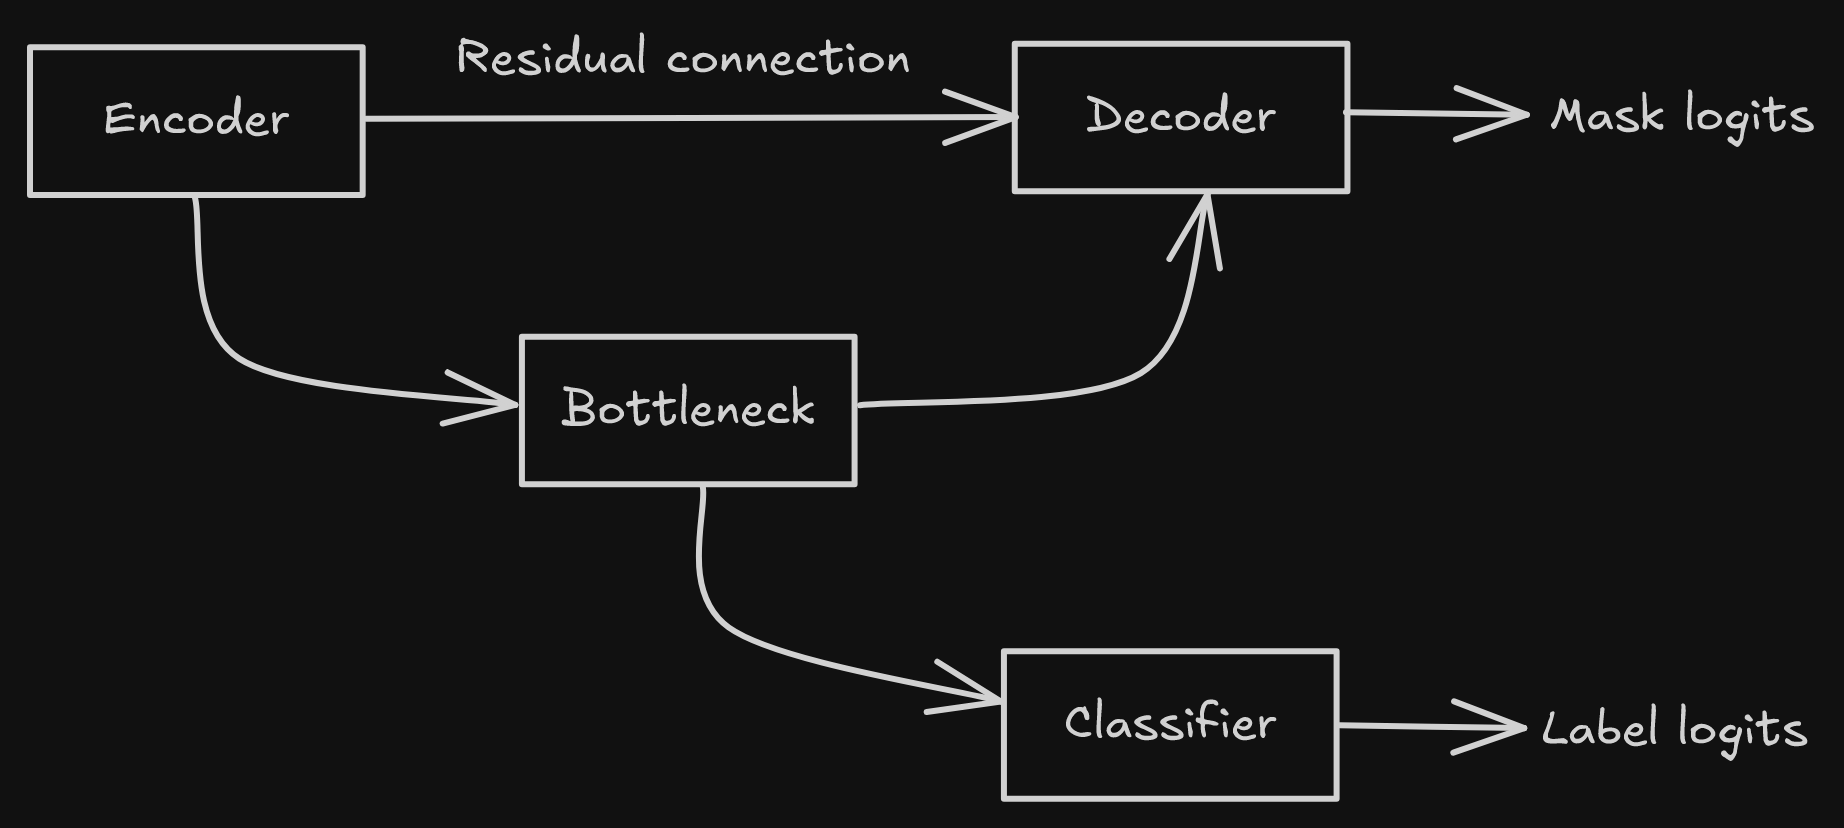

Lets define our classifier at first -

In [23]:
class Classifier(nn.Module):
    def __init__(self, in_channels = 32, num_classes = 3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels*2, 3)
        self.conv2 = nn.Conv2d(in_channels*2, in_channels, 3)
        self.conv3 = nn.Conv2d(in_channels, num_classes, 3)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2, stride = 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2, stride = 2)
        x = F.adaptive_avg_pool2d(self.conv3(x), (1, 1)).squeeze((-1,-2))

        return x

Now we just train together -

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_loader = BatchLoader(x_train, y_mask_train, y_train, shuffle = True, batch_size = 8, device = device)
test_loader = BatchLoader(x_test, y_mask_test, y_test, shuffle = False, batch_size = 8, device = device)

#instantiating U-Net
encoder = UNetEncoder(1, 8).to(device)
bottleneck = UNetBottleneck(32).to(device)
decoder = UNetDecoder(64).to(device)

#instantiating classifier
classifier = Classifier(64).to(device)

#optimizer needs the parameters from both the U-Net and classifier networks
optim = torch.optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr = 0.005)
dice_loss = DiceLoss()
bce_loss = nn.BCEWithLogitsLoss()

#class weights can be added for the classification part to get better training in imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

#classifier will need multi cross entropy as there are 3 classes
classifier_loss_fn = nn.CrossEntropyLoss(weight = class_weights.to(device))

epochs = 25

for epoch in range(epochs):
    print(f"Epoch - {epoch + 1}")

    train_bce_loss = 0
    train_dice_loss = 0
    train_iou = 0
    train_classifier_loss = 0
    train_correct = 0
    train_samples = 0

    encoder.train()
    decoder.train()

    for i in range(train_loader.len):
        x, y_label, y_mask = train_loader.next('both')
        x1, x2, x3 = encoder(x.unsqueeze(1))
        x4 = bottleneck(x3)
        y_predict_mask = decoder(x4, x3, x2, x1)
        y_predict_label = classifier(x4)

        bce = bce_loss(y_predict_mask, y_mask.float())
        dice = dice_loss(y_predict_mask, y_mask)
        classifier_loss = classifier_loss_fn(y_predict_label, y_label)

        #these weights may not give you the best results
        loss = (0.2*bce + 0.8*dice)/2 + 0.5*classifier_loss

        train_bce_loss += bce
        train_dice_loss += dice
        train_iou += calculate_iou(y_predict_mask, y_mask.float())
        train_classifier_loss += classifier_loss
        train_correct += (y_predict_label.argmax(dim = 1) == y_label).sum().item()
        train_samples += y_label.shape[0]

        optim.zero_grad()
        loss.backward()
        optim.step()

    print(f"Train BCE loss - {train_bce_loss/train_loader.len:4f}")
    print(f"Train Dice loss - {train_dice_loss/train_loader.len:4f}")
    print(f"Train IoU - {train_iou/train_loader.len:4f}")
    print(f"Train Classifier loss - {train_classifier_loss/train_loader.len:4f}")
    print(f"Train accuracy - {train_correct/train_samples:4f}")

    test_bce_loss = 0
    test_dice_loss = 0
    test_iou = 0
    test_classifier_loss = 0
    test_correct = 0
    test_samples = 0

    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        for i in range(test_loader.len):
            x, y_label, y_mask = test_loader.next('both')
            x1, x2, x3 = encoder(x.unsqueeze(1))
            x4 = bottleneck(x3)
            y_predict_mask = decoder(x4, x3, x2, x1)
            y_predict_label = classifier(x4)

            bce = bce_loss(y_predict_mask, y_mask.float())
            dice = dice_loss(y_predict_mask, y_mask)
            classifier_loss = classifier_loss_fn(y_predict_label, y_label)

            test_bce_loss += bce
            test_dice_loss += dice
            test_iou += calculate_iou(y_predict_mask, y_mask.float())
            test_classifier_loss += classifier_loss
            test_correct += (y_predict_label.argmax(dim = 1) == y_label).sum().item()
            test_samples += y_label.shape[0]

        print(f"\nTest BCE loss - {test_bce_loss/test_loader.len:4f}")
        print(f"Test Dice loss - {test_dice_loss/test_loader.len:4f}")
        print(f"Test IoU - {test_iou/test_loader.len:4f}")
        print(f"Test Classifier loss - {test_classifier_loss/test_loader.len:4f}")
        print(f"Test accuracy - {test_correct/test_samples:4f}\n")

Epoch - 1
Train BCE loss - 0.406287
Train Dice loss - 0.921179
Train IoU - 0.168359
Train Classifier loss - 1.089303
Train accuracy - 0.617264

Test BCE loss - 0.410134
Test Dice loss - 0.901975
Test IoU - 0.074672
Test Classifier loss - 1.088357
Test accuracy - 0.608696

Epoch - 2
Train BCE loss - 0.180041
Train Dice loss - 0.835100
Train IoU - 0.127393
Train Classifier loss - 1.085316
Train accuracy - 0.636808

Test BCE loss - 0.163144
Test Dice loss - 0.900567
Test IoU - 0.031087
Test Classifier loss - 1.090313
Test accuracy - 0.608696

Epoch - 3
Train BCE loss - 0.176461
Train Dice loss - 0.788486
Train IoU - 0.151163
Train Classifier loss - 1.084189
Train accuracy - 0.633550

Test BCE loss - 0.190887
Test Dice loss - 0.823281
Test IoU - 0.093938
Test Classifier loss - 1.087525
Test accuracy - 0.623188

Epoch - 4
Train BCE loss - 0.177637
Train Dice loss - 0.770154
Train IoU - 0.131179
Train Classifier loss - 1.086589
Train accuracy - 0.633550

Test BCE loss - 0.304057
Test Dice lo

The visualization after training has intentionally been left out.